# Get Packages, Data, Set Variables

In [249]:
!pip install apyori

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/03/96/274a769f29be5adfee600edb97b97cc7817a86903f2477f8ca9c60445bc3/mlxtend-0.23.2-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>=1.3.1 from https://files.pythonhosted.org/packages/cd/7a/19fe32c810c5ceddafcfda16276d98df299c8649e24e84d4f00df4a91e01/scikit_learn-1.5.2-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.6 MB/s eta 0:00:006.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 6.7 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninsta

In [1]:
!mkdir ~/.kaggle
!cp /Users/cenanaltunay/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/cenanaltunay/.kaggle: File exists


In [2]:
!kaggle datasets download aslanahmedov/market-basket-analysis

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis
License(s): copyright-authors
100%|██████████████████████████████████████| 22.8M/22.8M [00:04<00:00, 6.28MB/s]
100%|██████████████████████████████████████| 22.8M/22.8M [00:04<00:00, 5.27MB/s]


In [3]:
!unzip market-basket-analysis.zip

Archive:  market-basket-analysis.zip
  inflating: Assignment-1_Data.csv   
  inflating: Assignment-1_Data.xlsx  


In [171]:
!kaggle datasets download carrie1/ecommerce-data

Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
 97%|████████████████████████████████████▉ | 7.00M/7.20M [00:02<00:00, 4.82MB/s]
100%|██████████████████████████████████████| 7.20M/7.20M [00:02<00:00, 3.08MB/s]


In [177]:
!unzip ecommerce-data.zip

Archive:  ecommerce-data.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [14]:
import warnings
from IPython.display import display, Markdown

import numpy as np
import pandas as pd
import sweetviz as sv

import matplotlib.pyplot as plt
import seaborn as sns

from apyori import apriori

warnings.filterwarnings('ignore')
%matplotlib inline

# Read data

In [2]:
data_path = "ecommerce_data.csv"

df = pd.read_csv(data_path,
                 header = 0,
                 encoding = 'unicode_escape',
                 dtype = {'CustomerID': str,
                          'InvoiceID': str},
                 parse_dates = ['InvoiceDate'],
                 infer_datetime_format = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


# Initial Exploration of Data

                                             |      | [  0%]   00:00 -> (? left)


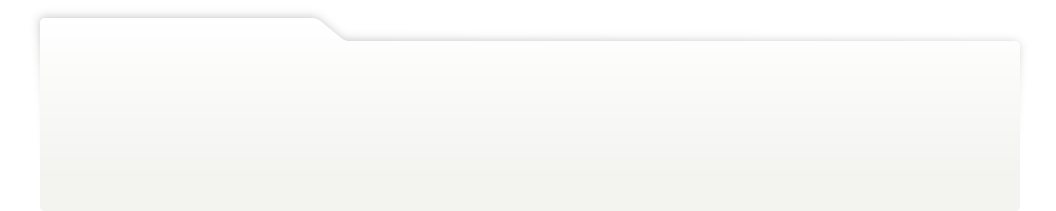
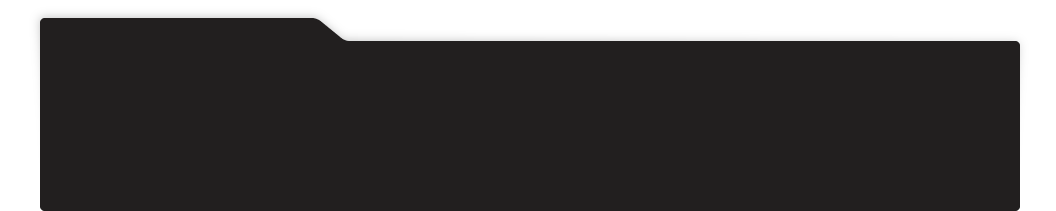
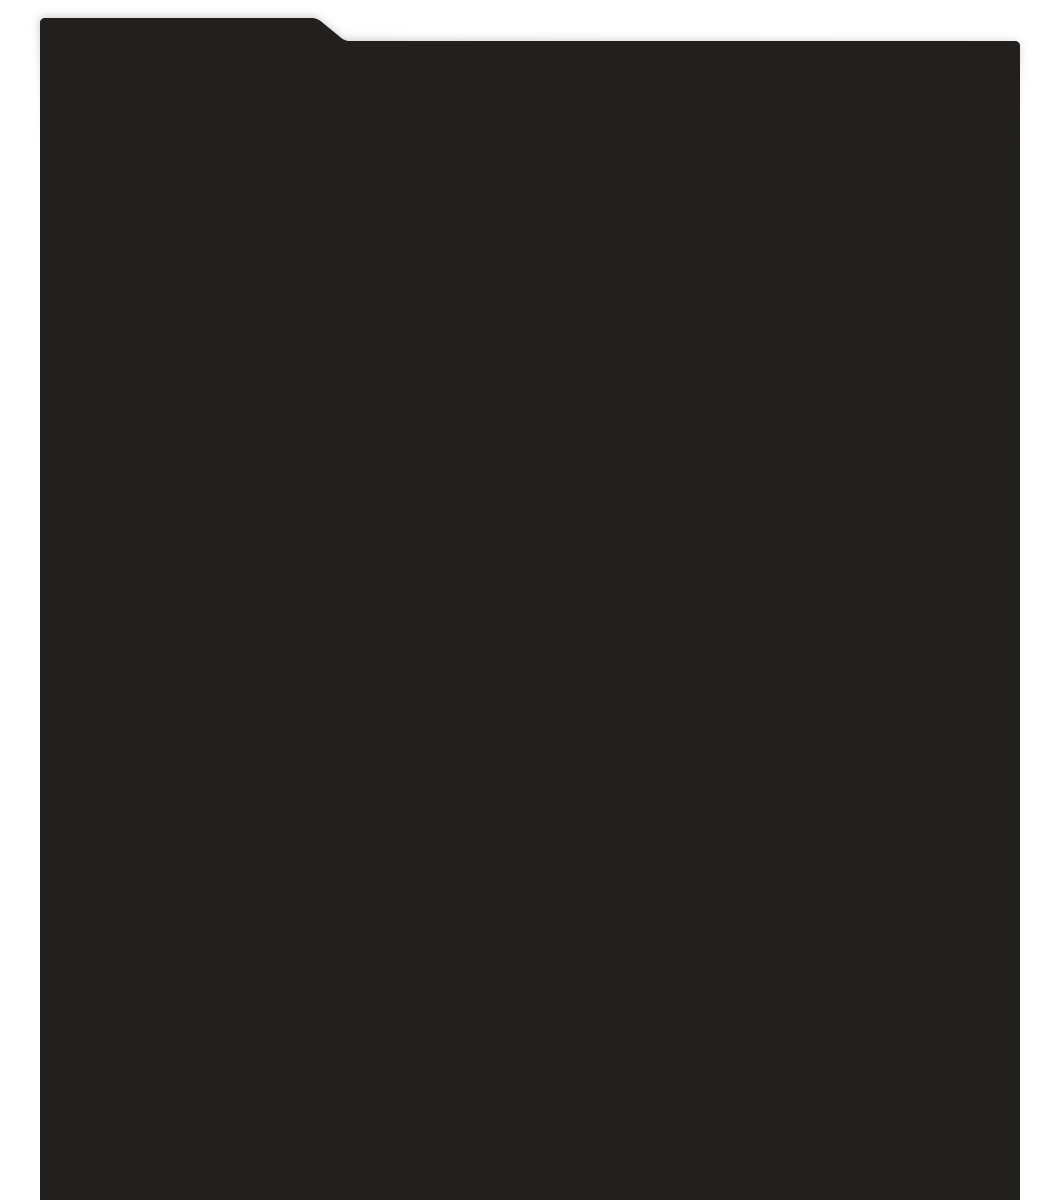
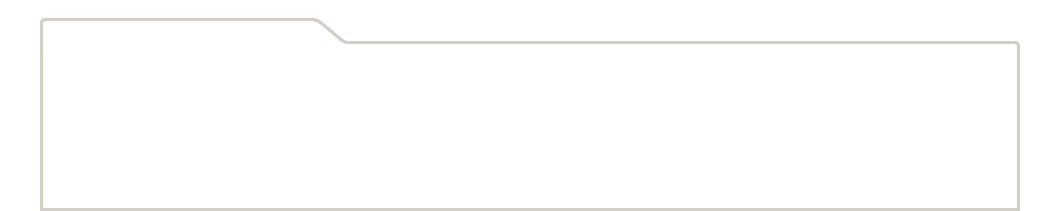
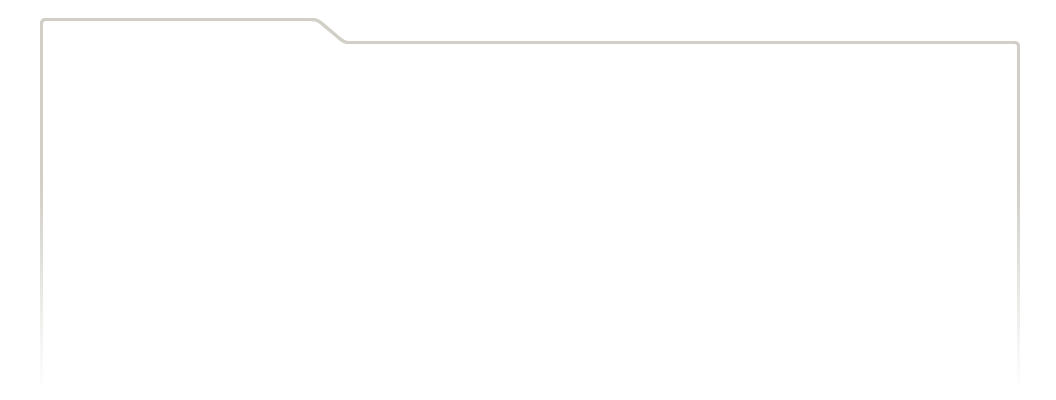
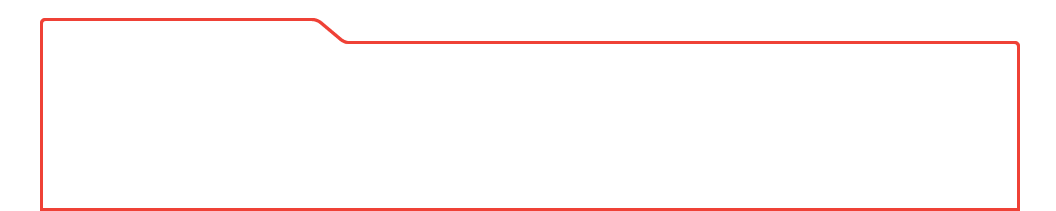
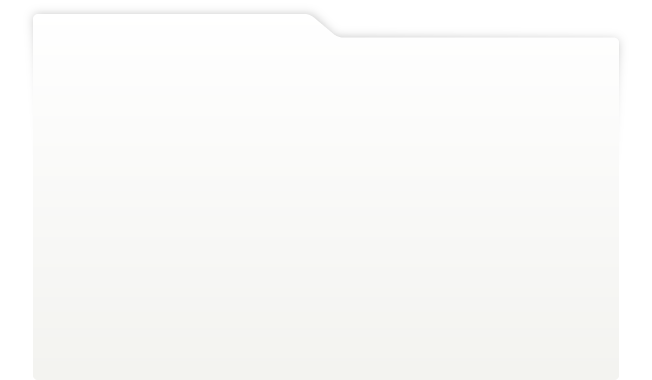
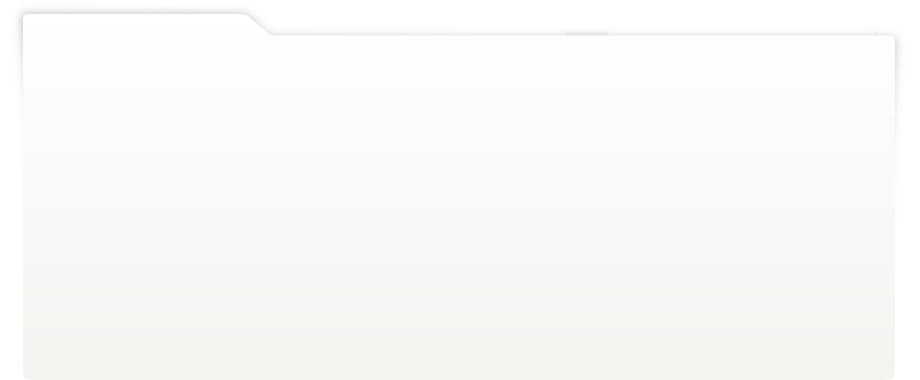
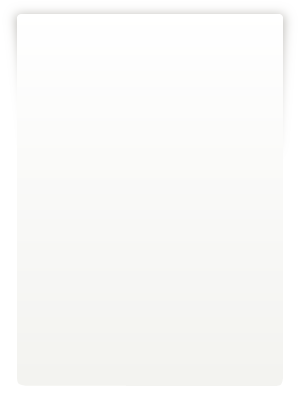
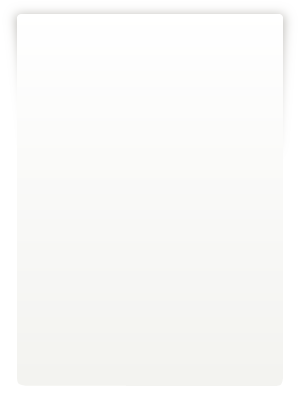
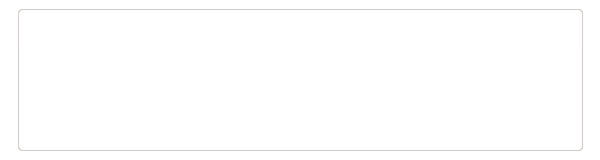
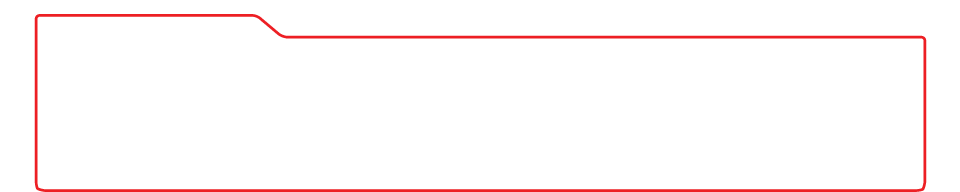
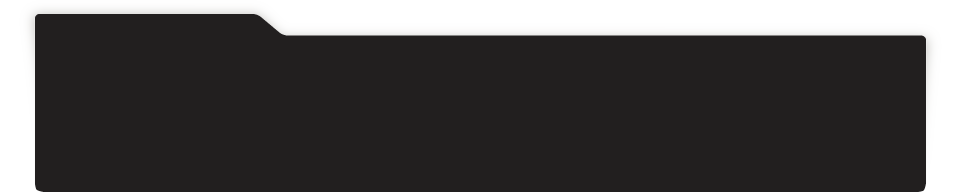
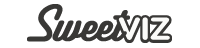
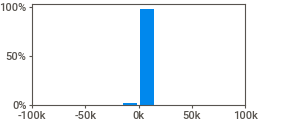
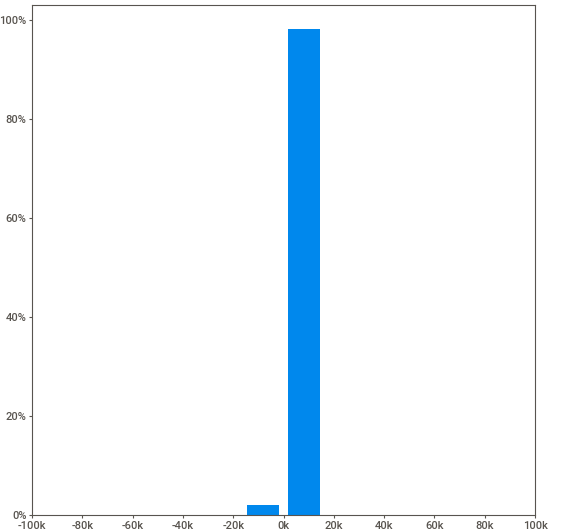
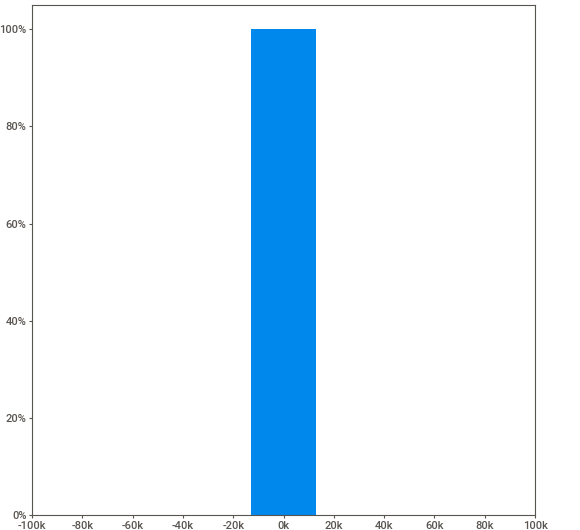
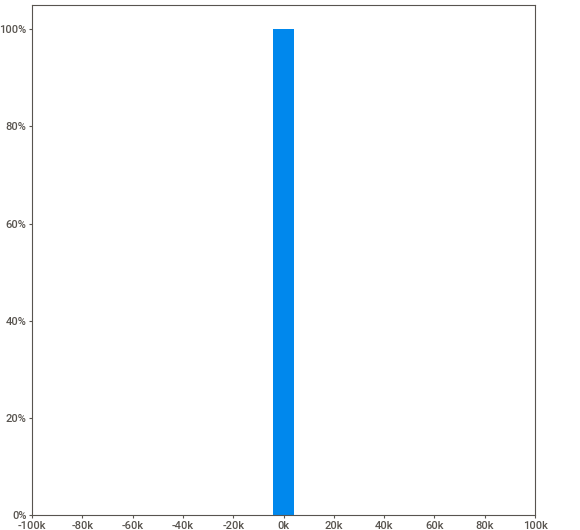
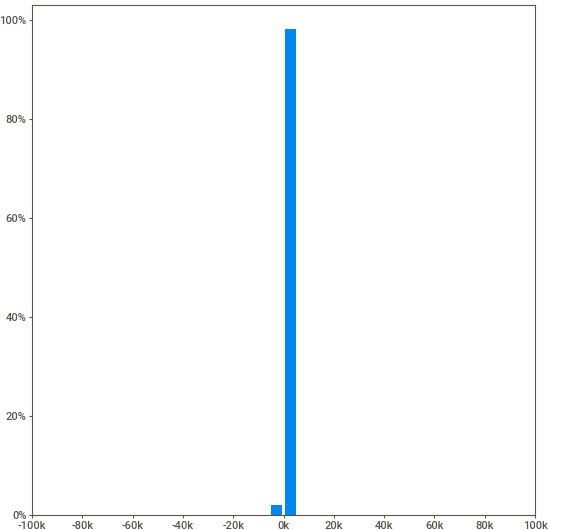
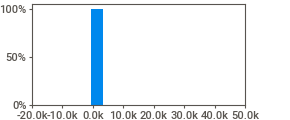
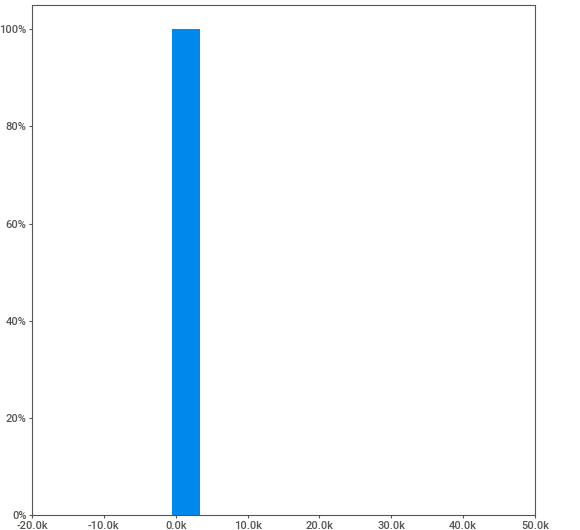
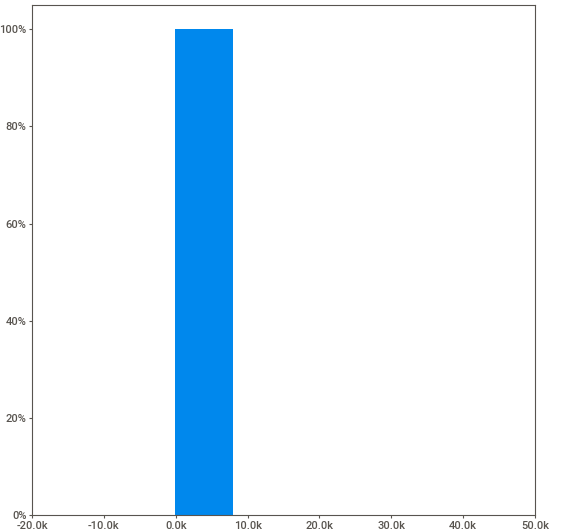
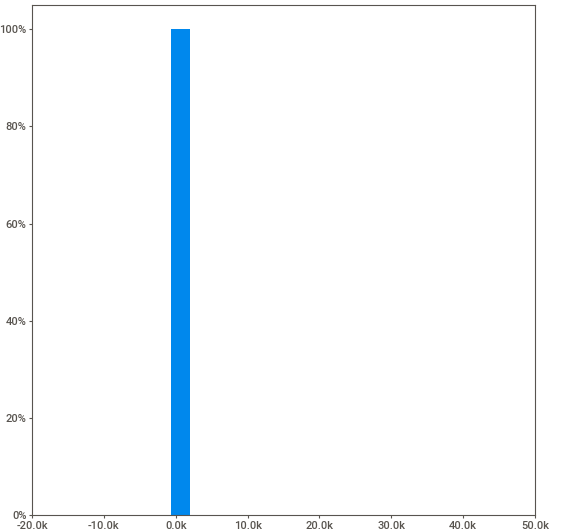
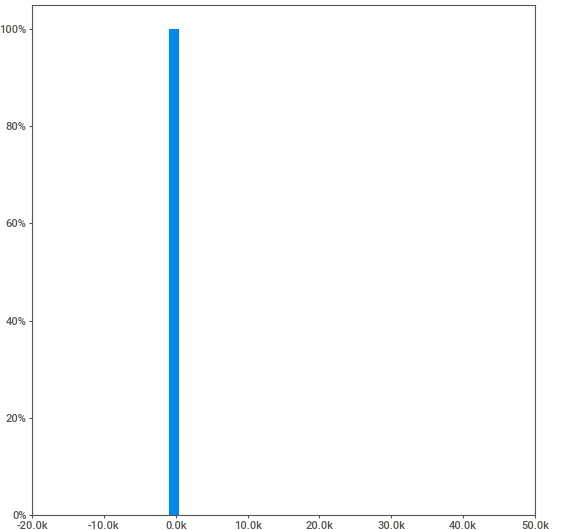
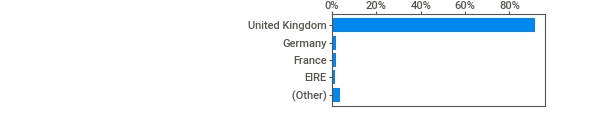
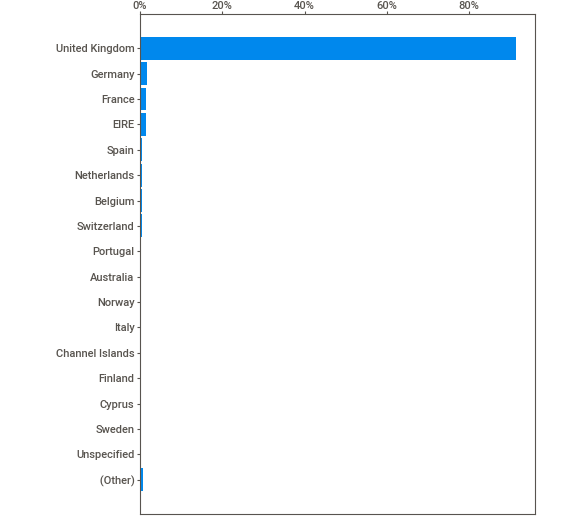
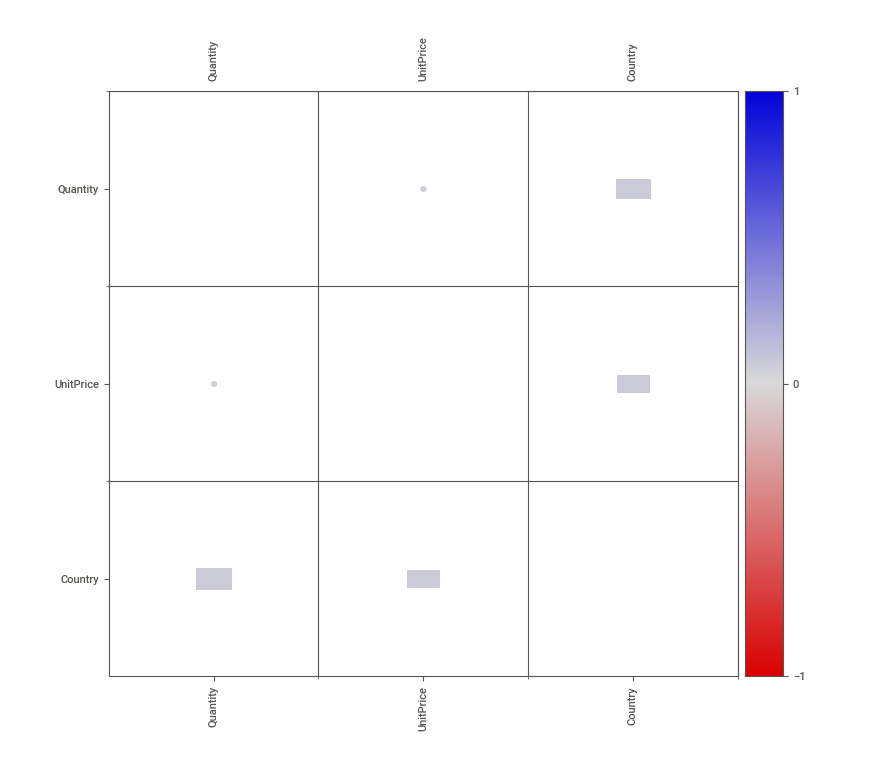
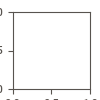

In [3]:
# create initial exploration reporting and show
report = sv.analyze(df)
report.show_notebook()

In [5]:
# Display the first few rows
display(Markdown("### Head of Dataset:"))
display(df.head())

### Head of Dataset:

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
# Check for duplicate rows
display(Markdown("### Number of Duplicate Rows:"))
display(pd.DataFrame({'Duplicate Rows': [df.duplicated().sum()]}))

### Number of Duplicate Rows:

,Duplicate Rows
0,5268


## Drop nulls as they are custoemrId, drop duplciates and calculate total sales per line

In [7]:
def preprocess_data(df):
    """
    Preprocesses the e-commerce data.
    """
    # Drop rows with missing values and reset the index
    df.dropna(inplace=True, ignore_index=True)

    # Remove duplicates
    df = df.drop_duplicates(ignore_index=True)

    # Filter out returns (negative quantities) and cancelled orders
    df = df[
        (df['Quantity'] > 0) &
        (df['UnitPrice'] > 0) &
        (~df['InvoiceNo'].astype(str).str.contains('C', case=False))
    ]

    # remove non-product items
    df = df.loc[
        (df['Description'] != 'POSTAGE')&
        (df['Description'] != 'DOTCOM POSTAGE')&
        (df['Description'] != 'Adjust bad debt')&
        (df['Description'] != 'Manual')]
    
    return df.reset_index(drop=True)

# Calculate total price per row
df['Total Sales Amount'] = df['Quantity'] * df['UnitPrice']

df = preprocess_data(df)

# Visualise Over time Sales and Avg. Customer Spent

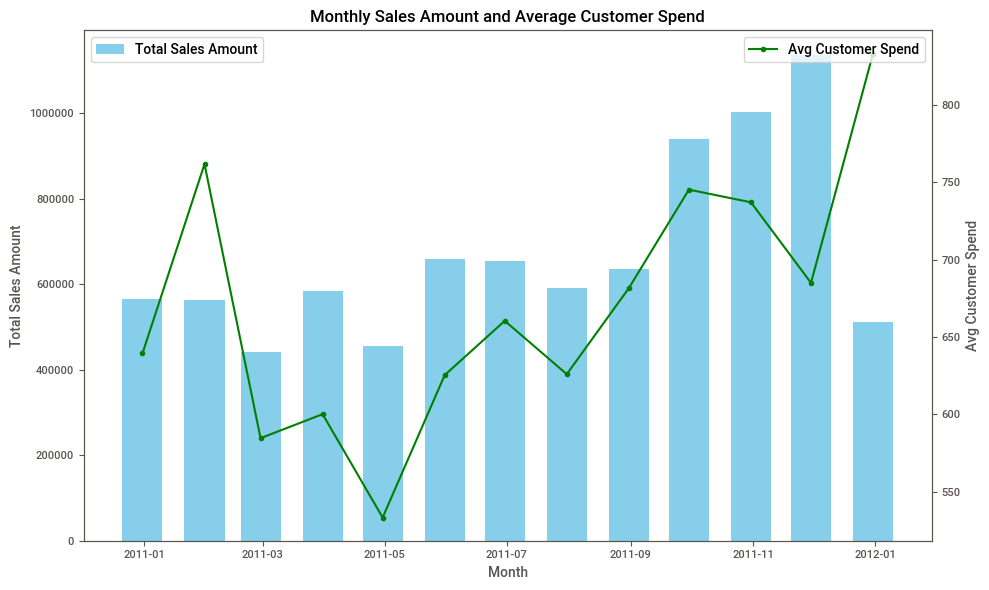

In [106]:
# Assuming df is your original DataFrame
df_vis = df.copy()

# Set 'InvoiceDate' as the index if it's not already
df_vis.set_index('InvoiceDate', inplace=True)

# Calculate monthly sales amount
monthly_sales = df_vis.resample('M').sum()[['Total Sales Amount']].reset_index()

# Calculate monthly average customer spend
monthly_customer_spend = df_vis.groupby(['CustomerID', pd.Grouper(freq='M')])['Total Sales Amount'].sum().reset_index()
monthly_avg_spend = monthly_customer_spend.groupby('InvoiceDate')['Total Sales Amount'].mean().reset_index()

# Merge monthly sales and average spend data for plotting
monthly_data = pd.merge(monthly_sales, monthly_avg_spend, on='InvoiceDate', suffixes=('', '_AvgCustomerSpend'))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for Total Sales Amount
ax.bar(monthly_data['InvoiceDate'], monthly_data['Total Sales Amount'], color='skyblue', width=20, label='Total Sales Amount')

# Create secondary y-axis and plot Average Customer Spend as a line chart
ax2 = ax.twinx()
ax2.plot(monthly_data['InvoiceDate'], monthly_data['Total Sales Amount_AvgCustomerSpend'], color='green', marker='o', label='Avg Customer Spend')

# Set axis labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Total Sales Amount')
ax2.set_ylabel('Avg Customer Spend')
ax.set_title('Monthly Sales Amount and Average Customer Spend')

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-tick labels for readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Most Popular Items

In [101]:
cm=sns.light_palette("green",as_cmap=True)

sold_units = df.groupby('Description').agg({'Quantity':'sum'}).sort_values(by='Quantity', ascending=False).head(10)
sold_units.style.background_gradient(cmap=cm)

,Quantity
Description,
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54319
JUMBO BAG RED RETROSPOT,46078
WHITE HANGING HEART T-LIGHT HOLDER,36706
ASSORTED COLOUR BIRD ORNAMENT,35263
PACK OF 72 RETROSPOT CAKE CASES,33670
POPCORN HOLDER,30919
RABBIT NIGHT LIGHT,27153


## Highest Revenue Items

In [10]:
cm=sns.light_palette("green",as_cmap=True)

sold_value = df.groupby('Description').agg({'Total Sales Amount':'sum'}).sort_values(by='Total Sales Amount', ascending=False).head(10)
sold_value.style.background_gradient(cmap=cm)

,Total Sales Amount
Description,
"PAPER CRAFT , LITTLE BIRDIE",168469.600000
REGENCY CAKESTAND 3 TIER,142264.750000
WHITE HANGING HEART T-LIGHT HOLDER,100392.100000
JUMBO BAG RED RETROSPOT,85040.540000
MEDIUM CERAMIC TOP STORAGE JAR,81416.730000
PARTY BUNTING,68785.230000
ASSORTED COLOUR BIRD ORNAMENT,56413.030000
RABBIT NIGHT LIGHT,51251.240000
CHILLI LIGHTS,46265.110000


# Market Basket Rules

In [16]:
transactions = df.groupby('InvoiceNo')['Description'].apply(list).tolist()

In [102]:
association_results = apriori(transactions, min_support=0.01, min_confidence=0.3, min_lift=1.0, min_length=2)

results_list = []
for result in association_results:
    for ordered_statistic in result.ordered_statistics:
        # Extract details and store them
        result_data = {
            'Antecedents': list(ordered_statistic.items_base),  # Left-hand side items (e.g. {Beer})
            'Consequents': list(ordered_statistic.items_add),   # Right-hand side items (e.g. {Nuts})
            'Support': result.support,                          # Support value
            'Confidence': ordered_statistic.confidence,         # Confidence value
            'Lift': ordered_statistic.lift                      # Lift value
        }
        results_list.append(result_data)

# Step 4: Convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

In [115]:
results_df.sample(10).to_csv('res.csv', index=False)

In [123]:
def recommend_items(df, item, top_n=3, sort_by='Lift'):
    """
    Recommend items to campaign based on association rules.

    Parameters:
    - df: DataFrame containing association rules with columns ['Antecedents', 'Consequents', 'Support', 'Confidence', 'Lift'].
    - item: The item for which to find recommendations.
    - top_n: The number of top items to return for each antecedent. Default is 3.
    - sort_by: The metric to sort the recommendations by. Options are 'Support', 'Confidence', 'Lift'. Default is 'Lift'.

    Returns:
    - None. Displays the recommended items with Markdown formatting.
    """
    # Check if the sort_by column is valid
    if sort_by not in ['Support', 'Confidence', 'Lift']:
        raise ValueError("sort_by must be one of ['Support', 'Confidence', 'Lift']")

    # Convert the input item to lowercase
    item = item.lower()

    # Filter the DataFrame for rows where the item is a substring of any of the Antecedents
    recommendations = df[df['Antecedents'].apply(
        lambda antecedents: any(item in i.lower() for i in antecedents)
    )]

    # Sort the recommendations by the specified metric
    recommendations = recommendations.sort_values(by=sort_by, ascending=False)

    # Dictionary to hold unique antecedents and their corresponding recommendations
    antecedent_recommendations = {}

    # Populate the dictionary
    for _, row in recommendations.iterrows():
        for antecedent in row['Antecedents']:
            if item in antecedent.lower():
                if antecedent not in antecedent_recommendations:
                    antecedent_recommendations[antecedent] = []
                consequents = ', '.join(row['Consequents'])
                lift = round(row['Lift'], 2)
                antecedent_recommendations[antecedent].append((consequents, lift))

    # Display the results using Markdown
    for antecedent, recs in antecedent_recommendations.items():
        display(Markdown(f"- **Top {top_n} Best Campaign Items to Match with '{antecedent}':**"))
        # Sort each antecedent's recommendations by lift and take the top_n
        top_recs = sorted(recs, key=lambda x: x[1], reverse=True)[:top_n]
        for consequents, lift in top_recs:
            display(Markdown(f"  - {consequents} \t {lift}"))
            
recommended_items = recommend_items(results_df, 'playhouse')
recommended_items

- **Top 3 Best Campaign Items to Match with 'POPPY'S PLAYHOUSE LIVINGROOM ':**

  - POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE BEDROOM  	 53.51

  - POPPY'S PLAYHOUSE BEDROOM  	 50.42

  - POPPY'S PLAYHOUSE KITCHEN 	 48.29

- **Top 3 Best Campaign Items to Match with 'POPPY'S PLAYHOUSE KITCHEN':**

  - POPPY'S PLAYHOUSE LIVINGROOM  	 53.51

  - POPPY'S PLAYHOUSE BEDROOM  	 50.42

  - POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOUSE BEDROOM  	 48.29

- **Top 3 Best Campaign Items to Match with 'POPPY'S PLAYHOUSE BEDROOM ':**

  - POPPY'S PLAYHOUSE LIVINGROOM  	 53.51

  - POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOUSE KITCHEN 	 50.42

  - POPPY'S PLAYHOUSE KITCHEN 	 48.29